In [24]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import fastf1
from scipy.optimize import curve_fit
fastf1.Cache.enable_cache('./f1cache')
from dataclasses import dataclass, field
import enum

In [ ]:
session = fastf1.get_session(2022, 'Belgium', 'R')
session.load(telemetry=True, laps=True, weather=True)
laps = session.laps
laps.head(0)

In [127]:
def get_traffic(lap: pd.DataFrame, dist=5):
    tel = lap.get_telemetry().copy(deep=True)
    driver_ahead = tel.query(f"DistanceToDriverAhead < {dist} and DriverAhead")
    driver_ahead.set_index("Date")["DriverAhead"]
    lap = lap.join(
        lap.set_index("LapStartDate")[["LapNumber"]] \
            .join(driver_ahead.set_index("Date")["DriverAhead"], how="outer") \
            .sort_index().rename({"DriverAhead": "Traffic"}, axis=1) \
            .fillna(method="ffill") \
            .groupby("LapNumber") \
            .count() > 1 \
        , on="LapNumber"
    )
    return lap

In [175]:
lec_lap = session.laps.query("Driver == 'LEC'")
sai_lap = session.laps.query("Driver == 'SAI'")

rus_lap = session.laps.query("Driver == 'RUS'")
ver_lap = session.laps.query("Driver == 'VER'")

In [169]:
def plot_driver_laptime_traffic(lap: pd.DataFrame):
    if "Traffic" not in lap:
        print("Getting traffic data")
        lap = get_traffic(lap, dist=1)
    traffic = lap.query("Traffic == True")
    no_traf = lap.query("Traffic == False")
    plt.scatter(traffic.LapNumber, traffic.LapTime.dt.total_seconds(), label="Traffic")
    plt.scatter(no_traf.LapNumber, no_traf.LapTime.dt.total_seconds(), label="No Traffic")
    plt.legend()

Getting traffic data
Getting traffic data


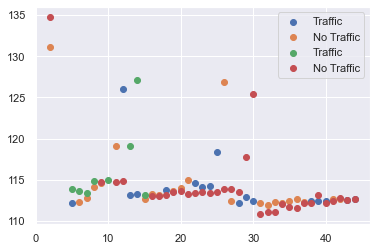

In [170]:
plot_traffic(sai_lap)
plot_traffic(rus_lap)

In [150]:
def plot_driver_laptime_tyre(lap: pd.DataFrame):
    class Tyre(enum.Enum):
        MEDIUM = "MEDIUM"
        HARD = "HARD"
        SOFT = "SOFT"
        INTERMEDIATE = "INTERMEDIATE"
        WET = "WET"
    tyreColor = {
        "MEDIUM": "yellow",
        "HARD": "black",
        "SOFT": "red",
        "INTERMEDIATE": "green",
        "WET": "blue"
    }
    for comp in tyreColor:
        lap_comp = lap.query(f"Compound == '{comp}'")
        if len(lap_comp):
            plt.scatter(lap_comp.LapNumber, lap_comp.LapTime.dt.total_seconds(), color= tyreColor[comp], label=comp)
    plt.legend()

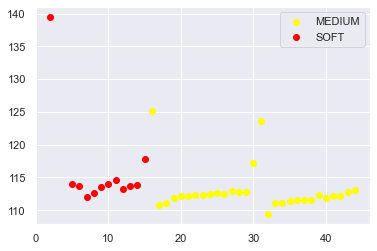

In [176]:
plot_driver_laptime_tyre(ver_lap)